In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

# Environment prep for Colab
 - download git repo 
 - install required pip packages

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
#!mkdir /content/drive/My\ Drive/Results
#MAIN_SAVE_DIR = '/content/drive/My Drive/Results'
#IMG_DIR = '/content/Generative_Models/data/.pokemon' #change .qbert here as well!git clone https://github.com/kkahloots/Generative_Models.git # this is for loading git with correct brach
#%cd /content/Generative_Models/
#!pip -q install -r /content/Generative_Models/requirements.txt
#!pip install colorlog==4.0.2
#%cd /content/

# Connect Drive to save and restore results

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#!mkdir /content/drive/My\ Drive/Results
#MAIN_SAVE_DIR = '/content/drive/My Drive/Results'
#IMG_DIR = '/content/Generative_Models/data/.pokemon' #change .qbert here as well

# Settings

In [5]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [6]:
#!pip -q install -r requirements.txt

In [7]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [8]:
os.getcwd()

'C:\\Users\\Kriple\\PycharmProjects\\pythonProject\\PokemonGAN\\notebooks'

In [9]:
os.chdir('..'+sep_local)
print(os.getcwd())

C:\Users\Kriple\PycharmProjects\pythonProject\PokemonGAN


# only on colab

In [10]:
#!cat data/.pokemon/pokemon.tar.part* > data/.pokemon/pokemon.tar

In [11]:
#!tar -xvf data/.pokemon/pokemon_combined.tar --directory data/.pokemon/

# Dataset loading

In [12]:
from generators.from_lmdb.lmdb_image_generator import get_generators

In [13]:
dataset_name='pokemon'
inputs_shape= image_shape=(100, 100, 3)
batch_size = 36
latents_dim = 256
intermediate_dim = 50
lmdb_dir = 'data/.pokemon_LMDB'

In [14]:
from transformation.lmdb_transformer import LmdbTransformer

In [15]:
train_generator, val_generator = get_generators(
        lmdb_dir=lmdb_dir,
        batch_size=batch_size,
        episode_len=None,
        episode_shift=None,
        return_itr=False
)

C:\Users\Kriple\PycharmProjects\pythonProject\PokemonGAN\transformation\file_image_generator.py:51: UserWarning: No files found
  warnings.warn(msg)


Initializing Iterator training Number of images 591
Initializing Iterator validation Number of images 218


In [16]:
import numpy as np
_instance_scale=1.0
for data in val_generator:
    print(np.max(data['images']))
    break
    #print(data.keys())

1.0


In [17]:
[*data['images'][0].shape]

[100, 100, 3]

In [18]:
data.keys()

dict_keys(['images', 'label'])

# Callbacks definition

In [19]:
restore_path = './saved_models/WGAN_GP'

# Model definition

In [20]:
from building.models import WGAN_GP

C:\Users\Kriple\PycharmProjects\pythonProject\PokemonGAN\utils\utils.py:33: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [21]:
gan_model = WGAN_GP(
                    model_name=dataset_name+'_WGAN_GP', 
                    save_path=restore_path, 
                    image_size=inputs_shape, 
                    z_dim=latents_dim, 
                    n_critic=5, 
                    batch_size=batch_size,
                    g_penalty=10
                   )

unable to restore ... 
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
up_conv2d (UpConv2D)         (None, 5, 5, 1200)        7680000   
_________________________________________________________________
batch_norm (BatchNorm)       (None, 5, 5, 1200)        4800      
_________________________________________________________________
re_lu (ReLU)                 (None, 5, 5, 1200)        0         
_________________________________________________________________
up_conv2d_1 (UpConv2D)       (None, 25, 25, 1200)      23040000  
_________________________________________________________________
batch_norm_1 (BatchNorm)     (None, 25, 25, 1200)      4800      
_________________________________________________________________
re_lu_1 (ReLU)               (None

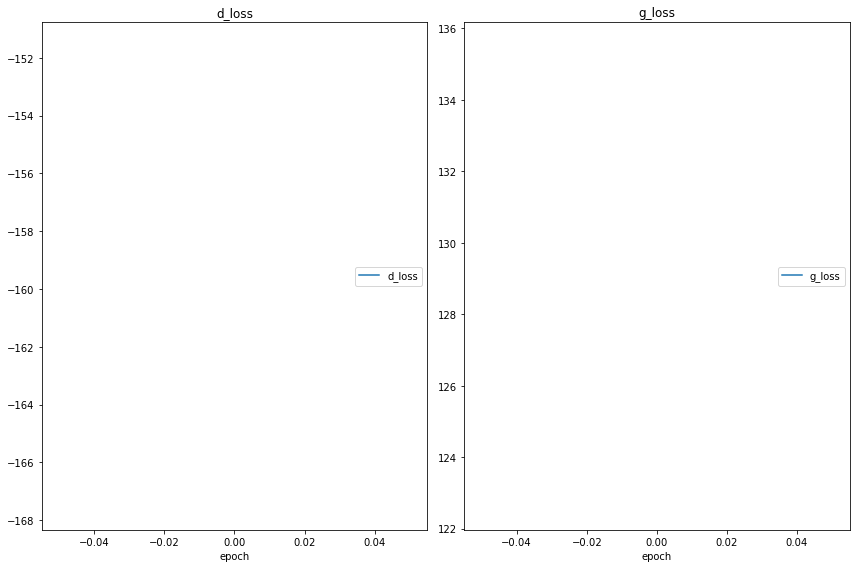

d_loss
	d_loss           	 (min: -159.553, max: -159.553, cur: -159.553)
g_loss
	g_loss           	 (min:  129.067, max:  129.067, cur:  129.067)
Epoch 2/20000


In [ ]:
gan_model.train(dataset=train_generator, start_epoch=0, epochs=int(2e4), n_itr=100)

In [ ]:
xxx

In [ ]:
#to restore trained model, set filepath=_restore

In [ ]:
ae = AE( 
    name=model_name,
    latents_dim=latents_dim,
    batch_size=batch_size,
    variables_params=variables_params, 
    filepath=_restore
    )

In [ ]:
ae.compile(metrics=None)

In [ ]:
ae.output_shape

# Callbacks

In [ ]:
from training.callbacks.sample_generation import SampleGeneration
from training.callbacks.save_model import ModelSaver

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-15, 
    patience=10, 
    verbose=1, 
    restore_best_weights=False
)

In [ ]:
ms = ModelSaver(filepath=_restore)

In [ ]:
csv_dir = os.path.join(experiments_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, ae.name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
csv_dir

In [ ]:
image_gen_dir = os.path.join(experiments_dir, 'image_gen_dir')
create_if_not_exist(image_gen_dir)

In [ ]:
sg = SampleGeneration(latents_shape=latents_dim, filepath=image_gen_dir, gen_freq=5, save_img=True, gray_plot=False)

# Model Training

In [ ]:
ae.fit(
    x=train_generator,
    input_kw='images',
    steps_per_epoch=5,#int(5e3),
    epochs=5,#int(1e6), 
    verbose=1,
    #callbacks=[es, ms, csv_log, sg],
    workers=-1,
    use_multiprocessing=True,
    validation_data=train_generator,
    validation_steps=int(1e4)
)

# Model Evaluation

## inception_score

In [ ]:
from evaluation.generativity_metrics.inception_metrics import inception_score

In [ ]:
is_mean, is_sigma = inception_score(ae, tolerance_threshold=1e-6, max_iteration=1000)
print(f'inception_score mean: {is_mean.compute()}, sigma: {is_sigma.compute()}')

## Frechet_inception_distance

In [ ]:
from evaluation.generativity_metrics.inception_metrics import frechet_inception_distance

In [ ]:
fis_score = frechet_inception_distance(ae, train_generator.as_numpy_iterator(), 
                                       tolerance_threshold=1e-6, 
                                       max_iteration=1000, 
                                       batch_size=32)
print(f'frechet inception distance: {fis_score.compute()}')

## perceptual_path_length_score

In [ ]:
from evaluation.generativity_metrics.perceptual_path_length import perceptual_path_length_score

In [ ]:
ppl_mean_score = perceptual_path_length_score(ae, train_generator.as_numpy_iterator(), 
                                              tolerance_threshold=1e-6, 
                                              max_iteration=1000, 
                                              batch_size=32)
print(f'perceptual path length score: {ppl_mean_score}')

## precision score

In [ ]:
from evaluation.generativity_metrics.precision_recall import precision_score

In [ ]:
_precision_score = precision_score(ae,  train_generator.as_numpy_iterator(), 
                                   tolerance_threshold=1e-6, 
                                   max_iteration=1000)
print(f'precision score: {_precision_score}')

## recall score

In [ ]:
from evaluation.generativity_metrics.precision_recall import recall_score

In [ ]:
_recall_score = recall_score(ae, train_generator.as_numpy_iterator(), tolerance_threshold=1e-6, max_iteration=1000)
print(f'recall score: {_recall_score}')

# Image Generation

## image reconstruction

### Training dataset

In [ ]:
from training.generators.from_images.image_generation_testing import reconstruct_from_a_batch

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'reconstruct_training_images_like_a_batch_dir')
create_if_not_exist(save_dir)

reconstruct_from_a_batch(ae, train_generator.as_numpy_iterator(), save_dir)

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'reconstruct_testing_images_like_a_batch_dir')
create_if_not_exist(save_dir)

reconstruct_from_a_batch(ae, val_generator.as_numpy_iterator(), save_dir)

## with Randomness

In [ ]:
from training.generators.from_images.image_generation_testing import generate_images_like_a_batch

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'generate_training_images_like_a_batch_dir')
create_if_not_exist(save_dir)

generate_images_like_a_batch(ae, train_generator.as_numpy_iterator(), save_dir)

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'generate_testing_images_like_a_batch_dir')
create_if_not_exist(save_dir)

generate_images_like_a_batch(ae, val_generator.as_numpy_iterator(), save_dir)

### Complete Randomness

In [ ]:
from training.generators.from_images.image_generation_testing import generate_images_randomly

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'random_synthetic_dir')
create_if_not_exist(save_dir)

generate_images_randomly(ae, save_dir)

In [ ]:
from training.generators.from_images.image_generation_testing import interpolate_a_batch

In [ ]:
from utils.data_and_files.file_utils import create_if_not_exist
save_dir = os.path.join(experiments_dir, 'interpolate_dir')
create_if_not_exist(save_dir)

interpolate_a_batch(ae, val_generator.as_numpy_iterator(), save_dir)